# Problem set 2

##Team
Please write here your names and team number.

* Team name
* Team members

##Using Colab with GitHub
To utilize GPU support for model training, we highly recommend to open this notebook with Google Colab. Simply, change the domain from 'github.com' to 'githubtocolab.com' and refresh the site to open the notebook in Colab.
If you haven't used Colab before with private repositories, make sure to grant Colab access to your private repositories (see screenshot) and after that just try to change the domain again.

Finally, you should make sure that you add a GPU to your Colab notebook. You can do so by clicking on `Runtime` →  `Change runtime type` → `Hardware accelerator`  →  `GPU`.

##Submission

Make sure that you always commit and push the changes you make in Colab back to GitHub. To do so from within a Colab notebook, click `File` → `Save a copy in GitHub`. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository. Only changes that are visible in your GitHub repository on the main branch will be considered for grading. If you close Colab in your browser without pushing your changes to GitHub or saving them on Google Drive, they will be lost.

Once the deadline has passed, you are not able to push to your repository anymore. In other words, there is no submit button which you need to press. You just need to ensure that all your work has been pushed to GitHub before the deadline.


# Table of Contents


*   [Overview](#overview)
*   [Climate Impact](#climate-impact)
*   [Background on coal power plants](#background)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology](#implementation)
*   [Results & Discussion](#results-and-discussion)
*   [References](#references)


<a name="overview"></a>
# Overview

Over the next sections of this notebook, you'll go through the steps of how to monitor coal power plants, leveraging satellite imagery and computer vision models. In the pursuit of this goal, some of the main contributions of this tutorial are:
- A [dataset of coal power plants' emissions](https://drive.google.com/drive/folders/1_Jsl__ZcmOOYhErA9wH5QM8SPRIEgbfj?usp=share_link), including images, metadata and labels.
- A [public GitHub repository](https://github.com/AndreCNF/ccai-ss23-ai-monitoring-tutorial) with auxiliary code for creating the dataset, fetching Sentinel 2 images and training computer vision models.

<a name="climate-impact"></a>
# Climate Impact

In a (data scientist's) utopian world, for every region of the world, every domain and every point in time, there would be perfectly formatted, reliable and easily accessible data. Unfortunately, that is not the case. Particularly in greenhouse gas emissions data, the quality and availability of data varies greatly, both geographically and along time. For instance, the USA has [CAMPD](https://campd.epa.gov/), where power generation and emissions are made publicly available for each power plant, on an hourly basis. Similarly, the EU has [ENTSOE](https://transparency.entsoe.eu/generation/r2/actualGenerationPerGenerationUnit/show) and Australia has [NEM](https://github.com/opennem/opennempy). But for most other areas of the world, either data of this kind of granularity is non-existent, made difficult to access or is self-reported by energy companies (with the reliability concerns that it carries). If we think outside of the power sector, such as in heavy industry or in the infamous scope 3 emissions from supply chains, data scarcity and other issues are even more problematic.

While ground-level sensors are hard to implement on a global scale and self-reported data can lead to unreliable and inconsistent data, there is one type of sensor that is global by nature: satellites. For domains where their emissions are visible from space, at least in one of the available remote sensing bands (e.g. [the 13 bands in the Sentinel 2 satellites](https://en.wikipedia.org/wiki/Sentinel-2#Spectral_bands)), we can aim to collect emission estimates across the whole world. And given that some regions have emissions data freely available, we can use that to train machine learning models so as to automate the emissions estimation process.

<a name="background"></a>
# Background on coal power plants

## Operation status

We can think of a coal power plant has having two main operational statuses: idle (`OFF`) or generating electricity (`ON`). Whithin the `ON` state, the power plant can generate different levels of energy, and cause more or less emissions in a proportional manner, which depend on its capacity (i.e. how much power can it generate at its maximum) and its capacity factor (i.e. what percentage of its capacity is it generating). But for the purposes of this tutorial, we only care about whether the power plant is `ON` or `OFF`.

Coal power plants tend to be used as baseload, i.e. being in a somewhat constant state of either `ON` or `OFF`, as can be seen later on in one of the data analysis plots, and are typically slow to ramp up and down. Thus, a snapshot of them every few days, such as from satellite images, should be enough to get a realistic picture of their operational status and emissions.

## Brief description of how a coal power plant works

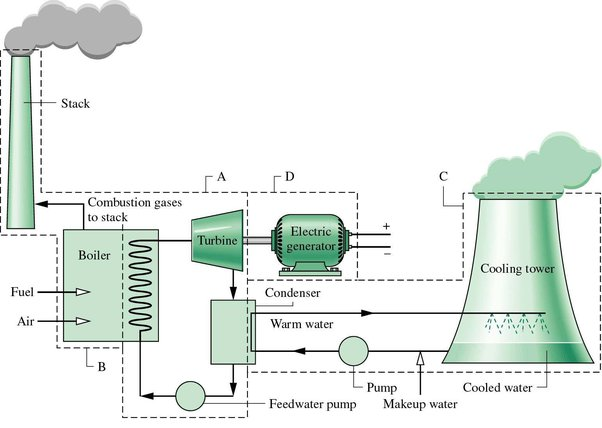

As a thermal energy source, coal power plants produce energy by heating up water and using its steam to turn a turbine. In the case of a coal power plant, it burns coal to produce the heat that steams up the water.

From an emissions standpoint, the main types of infrastructure in a coal power plant that we should care about are:
*   Flue stacks: a narrow and tall chimney where the waste gases from coal burning (including CO2) are vented out
*   Cooling technology: what's used to cool down the water that is heated up inside the power plant; some of the main cooling types are:
    *   Cooling towers: a wide and volumnous tower where the water cools down at a pool on the bottom of it while big plumes of water vapor come out
    *   Water outlet: in the once-through cooling method, the water that is pulled in to spin the turbine is then pushed straight out of the power plant (e.g. back to a river)

## Signals

Depending on the technology in use, coal power plants can have a set of signals that relate to their operational status and CO2 emissions:
*   Cooling tower plumes → generally very easily visible signal; we’ll focus on this one
    top-view-birds-eye-view-steam-pipes_518345-195.avif
*   Flue stack plumes → can be harder to spot, especially in medium to low-resolution images
    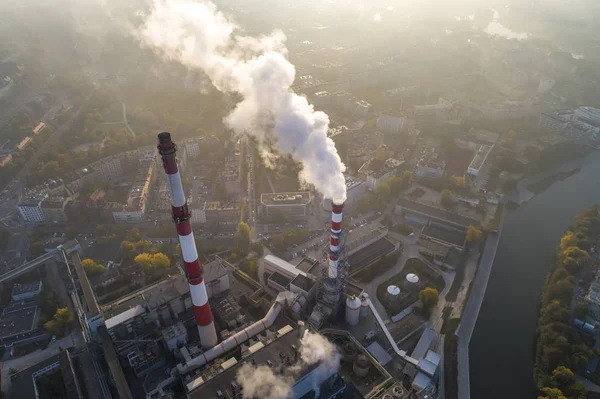
*   Flue stack and cooling tower heat → thermal data from satellites is still too low resolution to accurately model this
    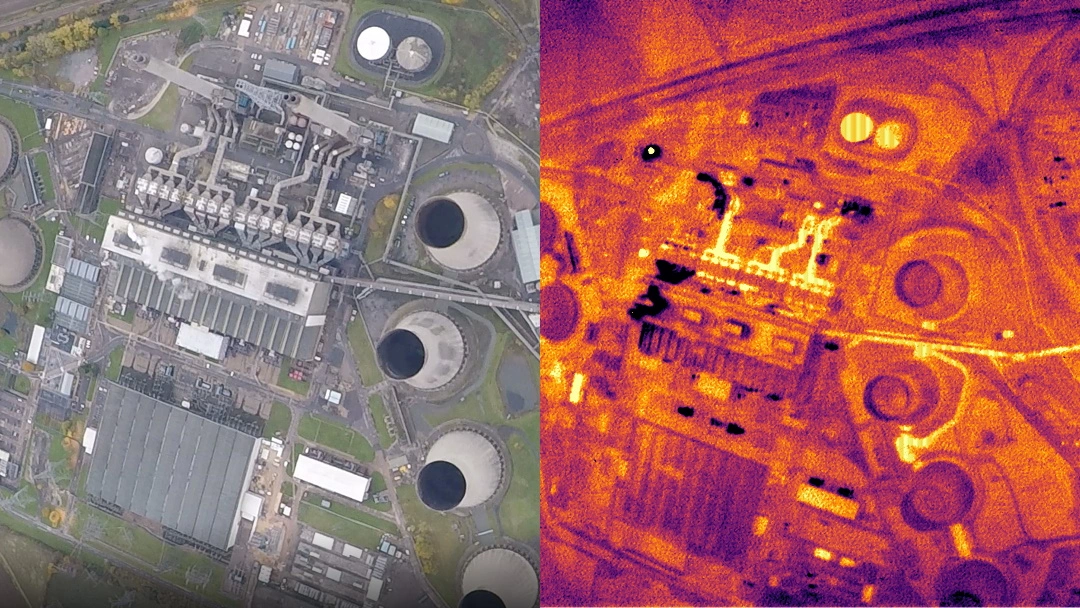
*   Cooling water flow → hard to decouple from nearby industrial activity

    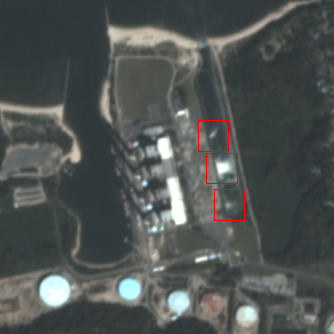


<a name="software-requirements"></a>
# Software Requirements

The main software dependency here is [coal_emissions_monitoring](https://github.com/AndreCNF/ccai-ss23-ai-monitoring-tutorial/), a Python library that was designed for this tutorial. It includes a lot of helper functions and notebooks to replicate this work, from dataset creation to machine learning model definition.

This colab was developed using Python 3.9.16, but should be able to work at least up to 3.10.

In [1]:
!python --version

Python 3.10.12


In [1]:
%%capture
!pip install git+https://github.com/AndreCNF/ccai-ss23-ai-monitoring-tutorial.git@ec25e47d0c29ab34c9afbf5b5c2d2de6b80db2b8
!pip install gdown


In [2]:
# Data visualization
import plotly.express as px
from ipywidgets import interact
from coal_emissions_monitoring.data_viz import view_satellite_image

# Data processing
import pandas as pd
import numpy as np
import geopandas as gpd
from coal_emissions_monitoring.dataset import CoalEmissionsDataModule, CoalEmissionsDataset

# Model training
import torch
import timm
import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from coal_emissions_monitoring.model import CoalEmissionsModel, SmallCNN

# Others
import os

/usr/local/lib/python3.10/dist-packages/pystac_client/client.py:186: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())


In [3]:
# set the random seed for reproducibility
GLOBAL_RANDOM_SEED = 42
L.seed_everything(GLOBAL_RANDOM_SEED)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

Check that the GPU  enabled in your colab notebook by running the cell below.

In [4]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


<a name="data-description"></a>
# Data Description

The data in this tutorial has been assembled using a combination of the following sources:
*   [AWS' Sentinel 2 L2A collection](https://registry.opendata.aws/sentinel-2-l2a-cogs/): satellite images made available both as the typical visible light images and as multispectral images; visual bands have a spatial resolution of 10 metres (i.e. each pixel represents ~10x10 square metres on the ground).
*   [Google's geospatial classification demo](https://github.com/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/geospatial-classification/labeled_geospatial_data.csv): dataset of timestamps and coordinates of cooling towers, with a label on whether or not its associated power plant was operating.

Our goal in the end is to be able to estimate the operation status of coal power plants through the satellite images, which is a proxy of their emissions.

The data has already been collected and processed in the [coal_emissions_monitoring](https://github.com/AndreCNF/ccai-ss23-ai-monitoring-tutorial/) repo, but feel free to check it for more information on how it was done. The main step taken there was downloading satellite images and associating them to each row of the labelled dataset.

## Data Download
All of the data required for this tutorial is made available in [this public Google Drive folder](https://drive.google.com/drive/folders/1ywJduPZYqOfPi3Sung93dlZnlmvYTOfK). We're just going to download it to this notebook's disk.

In [5]:
!gdown --folder https://drive.google.com/drive/folders/1TrgvYM7SW3Z9KQaohlPsCqehsZgWK8MA

Retrieving folder list
Processing file 1CGmfnNdIpukYobJaknbOBd1PEXdmC1h2 all_urls_dataset.csv
Processing file 193gcBwi2jUNNpBRk1riKUM6ntHu1Q9Fr final_dataset.csv
Processing file 18-3u46Ve4_Ioofd7YcAHErBDuPAoLw3a image_metadata.csv
Retrieving folder 1n123Hp_LVmMUBDvDfC3nftFTUfMidGaO images
Processing file 1JBLJoYlMgHI87GEvcBMZyjmoq_RYylyh .DS_Store
Processing file 1M8M_7prrLPcuNR-sWxDR8EpLuyfKFj41 all_bands_images.tar.gz
Processing file 1h_GsgpDpyrZZlyU_fvLpXokzjQh81CAC visual_images.tar.gz
Processing file 1ZP224rP-9jNMqkuainpwE2GjwT23UinJ labeled_geospatial_data.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1CGmfnNdIpukYobJaknbOBd1PEXdmC1h2
To: /content/data/all_urls_dataset.csv
100% 15.9M/15.9M [00:00<00:00, 149MB/s]
Downloading...
From: https://drive.google.com/uc?id=193gcBwi2jUNNpBRk1riKUM6ntHu1Q9Fr
To: /content/data/final_dataset.csv
100% 3.28M/3.28M [00:00<00:00, 273MB/s]

## Data Preprocessing

Here we're going to decompress our satellite images, configure a dataset and explore what's in the data.

Get the images from the compressed file (takes ~2 minutes):

In [6]:
!mkdir images
!tar -C images -xf data/images/visual_images.tar.gz
!rm -rf data/images/visual_images.tar.gz
images_path = "/content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual"

Setup the dataset:

In [7]:
batch_size = 64     # how many samples to use in each batch of model training
crop_size = 64      # what's the size in pixels to crop the satellite images to

In [8]:
data = CoalEmissionsDataModule(
    final_dataset_path="/content/data/final_dataset.csv", # path to the CSV file that contains the dataset that we're training on
    batch_size=batch_size,                                  # how many samples to use in each batch of model training
    crop_size=crop_size,                                    # what's the size in pixels to crop the satellite images to
    num_workers=os.cpu_count(),                             # how many workers to use to fetch the next batches of data while the model trains
    predownload_images=True,                                # whether to use predownloaded images or download them on the fly (very slow)
    download_missing_images=False,                          # whether or not to download any images that are missing from the dataset
    images_dir=images_path,                                 # path to where the images are saved on disk
)

In [9]:
# prepare the data for model training, i.e.
# • load the dataset table
# • filter out cloudy images (>50% of the satellite tile)
# • make sure that images are already downloaded and on the right path
# • split non-2020 data into training and validation sets, based on random spatial assignment
data.setup("fit")

In [10]:
# prepare the data for testing the model, i.e.
# • load the dataset table
# • filter out cloudy images (>50% of the satellite tile)
# • make sure that images are already downloaded and on the right path
# • assign all 2020 data to the test set
data.setup("test")

## Data exploration

For a clearer understanding, here's a description of each column in the dataset above:
*   `ts` - timestamp of when the operation status (i.e. `is_powered_on`) was recorded
*   `latitude` - latitude coordinate of the centre of the cooling tower
*   `longitude` - longitude coordinate of the centre of the cooling tower
*   `is_powered_on` - operation status of the power plant at the time `ts`; it's the label that we're going to estimate with our machine learning models; `1` means the power plant was `ON` (i.e. generating electricity), `0` is `OFF`
*   `facility_id` - unique identifier of the cooling tower
*   `geometry` - square-shaped geometry centred on the cooling tower, with dimensions of 640 x 640 metres, which represents 64 x 64 pixels in the Sentinel 2 satellite images
*   `cloud_cover` - percentage, from 0 to 100, that represents how much of the original satellite tile (which is 110 x 110 km) is estimated to be covered by clouds; **it's an important column** as clouds can obscure the power plants and trick our models to think that it's seeing cooling plumes; this is calculated using a combination of remote sensing arithmatics, you can see more information about it [here](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-1c/cloud-masks)
*   `cog_url` - URL for the Cloud Optimised GeoTIFF (COG) that contains the image that is relevant for the respective row (i.e. contains an image of the `geometry` taken at the date `ts`)
*   `local_image_path` - path to the image that was cropped from the `cog_url` using `geometry`, saved on the local disk
*   `data_set` - group that the respective sample corresponds to; can be `train`, if it's going to be used to train the model; `val`, if it's being used to validate the model's performance during training; `test`, if it's going to be used to test the model in unseen data after training

In [11]:
data.train_dataset.gdf

facility_id  latitude  longitude                               ts  \
596            15  50.99360    6.66418 2019-12-04 10:46:45.525000+00:00   
481            12  50.99311    6.66457 2021-02-11 10:46:50.147000+00:00   
671            17  50.99400    6.66879 2016-12-04 10:45:38.833000+00:00   
1938           44  51.67680    7.97625 2018-10-05 10:40:19.460000+00:00   
2920           66  51.27131   19.32624 2019-10-25 09:56:35.456000+00:00   
...           ...       ...        ...                              ...   
4284           92  50.83896    6.31914 2018-07-02 10:40:21.460000+00:00   
1157           28  34.12500  -84.92487 2019-09-17 16:34:06.112000+00:00   
2862           64  51.27130   19.32160 2018-04-08 09:52:39.940000+00:00   
2306           52  37.92798  -87.03403 2018-12-24 16:42:53.390000+00:00   
4516           97  50.83950    6.32016 2019-12-04 10:46:45.525000+00:00   

      is_powered_on  cloud_cover  \
596               1         3.88   
481               1         2.74   
671               1         0.00   
1938              1         0.26   
2920              1        29.30   
...             ...          ...   
4284              1         0.00   
1157              1         0.21   
2862              1         4.22   
2306              1         1.99   
4516              1         4.61   

                                                cog_url  \
596   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
481   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
671   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
1938  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
2920  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
...                                                 ...   
4284  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
1157  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
2862  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
2306  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
4516  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   

                                               geometry  \
596   POLYGON ((6.66859 50.99657, 6.66888 50.99082, ...   
481   POLYGON ((6.66898 50.99608, 6.66927 50.99033, ...   
671   POLYGON ((6.67320 50.99697, 6.67349 50.99122, ...   
1938  POLYGON ((7.98081 51.67972, 7.98094 51.67396, ...   
2920  POLYGON ((19.33072 51.27425, 19.33093 51.26850...   
...                                                 ...   
4284  POLYGON ((6.32352 50.84194, 6.32384 50.83619, ...   
1157  POLYGON ((-84.92133 34.12783, -84.92147 34.122...   
2862  POLYGON ((19.32608 51.27424, 19.32629 51.26849...   
2306  POLYGON ((-87.03039 37.93087, -87.03039 37.925...   
4516  POLYGON ((6.32454 50.84248, 6.32486 50.83673, ...   

                                       local_image_path data_set  
596   /content/images/Users/adminuser/GitHub/ccai-ss...    train  
481   /content/images/Users/adminuser/GitHub/ccai-ss...    train  
671   /content/images/Users/adminuser/GitHub/ccai-ss...    train  
1938  /content/images/Users/adminuser/GitHub/ccai-ss...    train  
2920  /content/images/Users/adminuser/GitHub/ccai-ss...    train  
...                                                 ...      ...  
4284  /content/images/Users/adminuser/GitHub/ccai-ss...    train  
1157  /content/images/Users/adminuser/GitHub/ccai-ss...    train  
2862  /content/images/Users/adminuser/GitHub/ccai-ss...    train  
2306  /content/images/Users/adminuser/GitHub/ccai-ss...    train  
4516  /content/images/Users/adminuser/GitHub/ccai-ss...    train  

[3305 rows x 10 columns]

In [12]:
print(
f"""
Training data stats:
• Number of rows: {len(data.train_dataset.gdf)}
• Number of power plants: {data.train_dataset.gdf.facility_id.nunique()}
• Time range: {data.train_dataset.gdf.ts.min()} - {data.train_dataset.gdf.ts.max()}

Validation data stats:
• Number of rows: {len(data.val_dataset.gdf)}
• Number of power plants: {data.val_dataset.gdf.facility_id.nunique()}
• Time range: {data.val_dataset.gdf.ts.min()} - {data.val_dataset.gdf.ts.max()}

Test data stats:
• Number of rows: {len(data.test_dataset.gdf)}
• Number of power plants: {data.test_dataset.gdf.facility_id.nunique()}
• Time range: {data.test_dataset.gdf.ts.min()} - {data.test_dataset.gdf.ts.max()}
"""
)


Training data stats:
• Number of rows: 3305
• Number of power plants: 133
• Time range: 2016-11-17 10:58:28+00:00 - 2021-04-27 10:46:46.734000+00:00

Validation data stats:
• Number of rows: 926
• Number of power plants: 23
• Time range: 2016-12-05 10:14:12.680000+00:00 - 2021-05-04 10:38:51.055000+00:00

Test data stats:
• Number of rows: 1887
• Number of power plants: 156
• Time range: 2020-01-02 10:26:23.818000+00:00 - 2020-12-31 09:18:43.139000+00:00



Note that the train/validation split is a spatial split, randomly allocating facilities to either the training or the validation set. This means that each unique cooling tower can either be in the training or validation set, but not on both at the same time. Precautions were taken to ensure that cooling towers that are very near each other, to the point of appearing in each others' images, would always be in the same set, so as to avoid leakage (e.g. similar images appearing both during training and validation, which could result in misleadingly high performance). For more information on this, check the `get_facility_set_mapper` function in [ccai-ss23-ai-monitoring-tutorial](https://github.com/AndreCNF/ccai-ss23-ai-monitoring-tutorial).

The test set includes all power plants but only has 2020 data, while the other sets have data for the years of 2016, 2017, 2018, 2019 and 2021.

You can notice that, while some cooling towers have some variations in their power generation, most spend the majority of the time generating power (`is_powered_on` = `1`).

In [13]:
all_co2_data = pd.concat(
    [
        data.train_dataset.gdf[["data_set", "is_powered_on"]],
        data.val_dataset.gdf[["data_set", "is_powered_on"]],
    ]
)
all_co2_data = (
    all_co2_data
    .groupby(["data_set", "is_powered_on"])
    .value_counts()
    .rename("number of samples")
    .to_frame()
    .reset_index()
)
all_co2_data.is_powered_on = all_co2_data.is_powered_on.apply(
    lambda x: "ON" if x == 1 else "OFF"
)
all_co2_data.rename(columns={"is_powered_on": "operation status"}, inplace=True)
px.bar(
    all_co2_data,
    x="operation status",
    y="number of samples",
    title="Histogram of operation status",
    color="data_set",
    barmode="group",
)

The histogram above reinforces the idea that coal power plants are generating electricity very often.

As the operation status is the label that we want to classify with a machine learning model, this disparity between positive and negative states actually constitutes a problem called an unbalanced dataset. With one class (`ON`) having many more observations than the other (`OFF`), if handled incorrectly it could trick our models to always predict that a power plant is `ON`. Fortunately there are ways to counteract this issue, such as applying a smaller weight to `ON` samples in the model's loss function, which makes the model pay relatively more attention to `OFF` samples.

In [16]:
all_cloud_data = pd.concat(
    [
        data.train_dataset.gdf[["data_set", "cloud_cover"]],
        data.val_dataset.gdf[["data_set", "cloud_cover"]],
    ]
)
px.histogram(
    all_cloud_data,
    x="cloud_cover",
    title="Histogram of cloud cover",
    color="data_set",
)

The cloud cover histogram shows us that most images are relatively cloudless, with most of them having between 0% to 0.5% clouds (and this is an estimate over the entire tile that the satellite captured, not just on the small patch that we extracted). So hopefully clouds won't be much of an issue.

Note that, in this plot, `cloud_cover` is represented as a percentage of the satellite tile.

Map of the cooling towers in the dataset, split by training and validation set:

(note that the squares represent the size and shape of the images that were retrieved for each cooling tower on each timestamp)

In [17]:
facilities_to_map = data.train_dataset.gdf[["facility_id", "geometry", "data_set"]].drop_duplicates()
facilities_to_map = facilities_to_map.append(data.val_dataset.gdf[["facility_id", "geometry", "data_set"]].drop_duplicates())
facilities_to_map.explore(column="data_set", cmap=["blue", "red"])

<ipython-input-17-d8c1762f119a>:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



<a name="Implementation"></a>
# Implementation

## Core model

For the purposes of this tutorial, a relatively simple model was defined from scratch, based on common features of modern Convolutional Neural Networks. It consists of:
*   6 convolutional layers with `ReLU` activation function
*   2 max pooling layers interspersed between the convolutional layers
*   1 adaptive average pooling layer after the final convolutional layer
*   1 fully connected layer in the end for estimating the final logit (i.e. the value that is used to estimate if a cooling tower is `ON` or `OFF`)

You are encouraged to try using other models, such as those made available in [Hugging Face's timm library](https://huggingface.co/docs/timm), but note that most popular computer vision models were developed with larger image sizes (e.g. 256 x 256 pixels instead of our current maximum size of 64 x 64 pixels).

## Early stopping

In order to be productive with training time, we're using a common technique called early stopping. What it does is end model training if a specific validation metric hasn't improved for a certain number of training epochs. In this case, we're early stopping model training if the loss on the validation set doesn't decrease for 10 consecutive epochs.

## Model checkpoints

As we monitor model performance during training, we can keep an eye on when is the model performing at its best. Since it's not guaranteed that the best model will be the one that comes out at the very end of training, we use model checkpoints to continuously save the model whenever we detect a new best performance over a given metric (in this case, its the balanced accuracy over the validation set).

In [14]:
model = SmallCNN(num_input_channels=3, num_classes=1)
lit_model = CoalEmissionsModel(
    model=model,
    learning_rate=1e-3,
    pos_weight=data.pos_weight,
)

## Train a model over the entire training set

**Note:** these cells should take around 10-15 minutes to run. Feel free to go make yourself a coffee while you wait ☕️

In [15]:
trainer_config = {'max_epochs': 100,
 'callbacks': [EarlyStopping(monitor="val_loss", mode="min", patience=10, min_delta=0.00),
        ModelCheckpoint(
            dirpath="/content/models/",
            filename="{val_loss:.3f}-{val_balanced_accuracy:.1%}-{epoch}-full_data",
            monitor="val_balanced_accuracy",
            mode="max",
        )],
 'limit_train_batches': round(1 * len(data.train_dataset.gdf) / batch_size),
 'limit_val_batches': round(1 * len(data.val_dataset.gdf) / batch_size),
 'reload_dataloaders_every_n_epochs': 1,
 'precision': '16-mixed',
 'accelerator': 'gpu',
 'logger': True,
 'log_every_n_steps': 1}


In [16]:
trainer = Trainer(**trainer_config)
trainer.fit(lit_model, data)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type              | Params
--------------------------------------------
0 | model | SmallCNN          | 282 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
282 K     Trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

2023-10-18 18:54:57.985 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180717_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:54:57.995 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:54:58.033 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180520_0_L2A_TCI_8.99863999999921

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 18:55:18.970 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:55:18.978 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180717_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:55:19.075 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180520_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 18:55:36.671 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:55:36.825 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:55:36.888 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 18:55:53.505 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:55:53.853 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20191219_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:55:53.891 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180818_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 18:56:10.511 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190214_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:56:10.611 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:56:10.623 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20181017_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 18:56:28.251 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20191219_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:56:28.664 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210213_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:56:28.711 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 18:56:45.656 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:56:45.701 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180520_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:56:45.905 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190806_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 18:57:04.064 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:57:04.118 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:57:04.263 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20181211_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 18:57:20.905 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:57:21.011 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:57:21.053 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180505_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 18:57:37.743 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20181017_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:57:37.770 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180818_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:57:37.839 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 18:57:55.262 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:57:55.474 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:57:55.477 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 18:58:11.930 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:58:12.070 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20191219_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:58:12.106 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921

In [17]:
_ = trainer.test(
    model=lit_model,
    dataloaders=data,
    ckpt_path="best",
    verbose=True,
)

INFO: Restoring states from the checkpoint path at /content/models/val_loss=0.164-val_balanced_accuracy=68.5%-epoch=7-full_data.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/models/val_loss=0.164-val_balanced_accuracy=68.5%-epoch=7-full_data.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/models/val_loss=0.164-val_balanced_accuracy=68.5%-epoch=7-full_data.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/models/val_loss=0.164-val_balanced_accuracy=68.5%-epoch=7-full_data.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 18:58:37.889 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200417_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:58:37.945 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200807_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 18:58:38.346 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200328_0_L2A_TCI_8.99863999999921

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5216925740242004     │
│  test_balanced_accuracy   │    0.6089407204714968     │
│         test_loss         │    0.21776437759399414    │
│      test_precision       │     0.888054609298706     │
│        test_recall        │    0.46640294790267944    │
└───────────────────────────┴───────────────────────────┘

## Task 1: implement MySmallCNN
Implement a variation of SmallCNN, class `MySmallCNN`, which generalizes the above-mentioned structure. You should create a model that implements a number of blocks (`num_blocks`), each having the following structure:
<ul>
  <li> A convolutional layer with output shape <code>conv_output_channels</code> and tunable kernel and padding (here a <a href="https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md">visual explanation</a> of their meaning). The convolution layer should be activated using ReLU.
  </li>
  <li> A max-pooling layer, again with tunable kernel size. For the final block, use an average pooling with an output size of 1 instead (for an explanation of the different pooling strategies see <a href="https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/">here</a>).
  </li>
</ul>

Finally, add one last fully-connected output layer. You do not need to apply an output function to the final layer, as the loss function used by the `CoalEmissionsModel` already includes a sigmoid transformation before computing the binary cross-entropy loss (`BCEWithLogitsLoss`).
 ***A few notes***:
You don't have to implement your model in `pytorch`, any DL library of your choice works. However, you might encounter some compatibility issues when training with `lightning`.
You also want to make sure that the dimension of the layers are compatible with each other and that the output of the algorithm can be adapted for classification problems for an arbitrary number of classes `num_classes`. Finally, while testing your implementation, you may want to turn on the parameter `fast_dev_run` in your trainer configuration, so that you will only test its functioning for a few loops.


In [18]:

from collections import OrderedDict

class MySmallCNN(torch.nn.Sequential):

  def __init__(self,
               num_input_channels=3,
               num_blocks=1,
               num_classes=1,
               conv_output_channels=32,
               conv_kernel_size=3,
               conv_padding=1,
               pool_kernel_size=2):

    super(MySmallCNN, self).__init__()

    # store layers in a list
    self.layers = []

    #append the first convolutional layer

    self.layers.append(("conv_0", torch.nn.Conv2d(in_channels=num_input_channels,
                                                   out_channels=conv_output_channels,
                                                   kernel_size=conv_kernel_size,
                                                   padding=conv_padding)))

    # append the first ReLU activation layer

    self.layers.append(("relu_0", torch.nn.ReLU()))

    # append the first max pooling layer

    self.layers.append(("pool_0", torch.nn.MaxPool2d(kernel_size=pool_kernel_size)))

    # append the remaining convolutional layers

    for i in range(2, num_blocks + 1):

       # append the convolutional layer
       self.layers.append(("conv_{}".format(i), torch.nn.Conv2d(in_channels=conv_output_channels,
                                                                out_channels=conv_output_channels,
                                                                kernel_size=conv_kernel_size,
                                                                padding=conv_padding)))

         # append the ReLU activation layer
       self.layers.append(("relu_{}".format(i), torch.nn.ReLU()))

         # append the max pooling layer
       self.layers.append(("pool_{}".format(i), torch.nn.MaxPool2d(kernel_size=pool_kernel_size)))


    # append the final fully connected layer

    self.layers.append(("conv_out", torch.nn.Conv2d(in_channels=conv_output_channels,
                                                     out_channels=num_classes,
                                                     kernel_size=1)))

    self.layers.append(("relu_out", torch.nn.ReLU()))

    self.layers.append(("adaptive_pool", torch.nn.AdaptiveAvgPool2d(output_size=1)))


    # connect all the layers together

    self.layers.append(("flatten", torch.nn.Flatten()))

    self.layers.append(("fc_out", torch.nn.Linear(in_features=num_classes,
                                                    out_features=num_classes)))

    self.layers = torch.nn.Sequential(OrderedDict(self.layers))




    def forward(self, x):
        # Define the custom forward pass
        return self.layers(x)



Once your class has been implemented, we initialize a `my_model` and a `my_trainer` objects and train the network on the data. Please remember to show the output of your run when uploading this notebook!

In [19]:
my_model = MySmallCNN(num_input_channels=3, num_blocks=2, conv_output_channels=32)
my_lit_model = CoalEmissionsModel(
    model=my_model,
    learning_rate=1e-3,
    pos_weight=data.pos_weight,
)

In [20]:
my_trainer_config = {'max_epochs': 100,
 'callbacks': [EarlyStopping(monitor="val_loss", mode="min", patience=10, min_delta=0.00),
        ModelCheckpoint(
            dirpath="/content/my_models/",
            filename="{val_loss:.3f}-{val_balanced_accuracy:.1%}-{epoch}-full_data",
            monitor="val_balanced_accuracy",
            mode="max",
        )],
 'limit_train_batches': round(1 * len(data.train_dataset.gdf) / batch_size),
 'limit_val_batches': round(1 * len(data.val_dataset.gdf) / batch_size),
 'reload_dataloaders_every_n_epochs': 1,
 'precision': '16-mixed',
 'accelerator': 'gpu',
 'logger': True,
 'log_every_n_steps': 1}


In [21]:
my_trainer = Trainer(**my_trainer_config)
my_trainer.fit(my_lit_model, data)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type              | Params
--------------------------------------------
0 | model | MySmallCNN        | 10.2 K
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
10.2 K    Trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [23]:
_ = my_trainer.test(
    model=my_lit_model,
    dataloaders=data,
    ckpt_path="best",
    verbose=True,
)

INFO: Restoring states from the checkpoint path at /content/my_models/val_loss=0.229-val_balanced_accuracy=50.3%-epoch=23-full_data.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/my_models/val_loss=0.229-val_balanced_accuracy=50.3%-epoch=23-full_data.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/my_models/val_loss=0.229-val_balanced_accuracy=50.3%-epoch=23-full_data.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/my_models/val_loss=0.229-val_balanced_accuracy=50.3%-epoch=23-full_data.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 19:16:12.471 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200807_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:16:12.501 | WARNING  | coal_emissions_monitoring.dataset:__iter__:122 - Could not load local image at nan. Original error: expected str, bytes or os.PathLike object, not float
2023-10-18 19:16:12.541 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200805_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:16:12.562 | WARNING  | coal_emissions_monitoring.datas

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8055704236030579     │
│  test_balanced_accuracy   │            0.5            │
│         test_loss         │    0.24218861758708954    │
│      test_precision       │    0.8055704236030579     │
│        test_recall        │            1.0            │
└───────────────────────────┴───────────────────────────┘

### Test your code

Use the following lines of code to test your code. Remember to show all output codes in the uploaded solution.

In [24]:
for batch in data.val_dataloader():
    break
my_preds = my_lit_model(batch["image"])
my_preds = torch.sigmoid(my_preds)

In [25]:
global fig
@interact
def view_pred_sample(sample_index = range(len(my_preds))):
    global fig
    print(f"Reported power plant operation: {'ON' if batch['target'][sample_index] == 1 else 'OFF'}")
    print(f"Estimated power plant operation: {'ON' if my_preds[sample_index] > 0.5 else 'OFF'} (probability: {my_preds[sample_index]:.1%})")
    fig = view_satellite_image(batch["image"][sample_index])

interactive(children=(Dropdown(description='sample_index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

In [31]:

# run this cell after selecting the sample index above
# to view the image
fig

## Task 2: fine tune your model hyperparameters with MyTuner

In the second task, you will have to implement a hyperparameter tuner from scratch and use it to tune the hyperparameters for `MySmallCNN`. The hyperarameter tuner should:
<ul>
<li> be implemented from scratch without the help of DL libraries (you may resort to default libraries such as <code>numpy</code>, <code>collections</code> or <code>itertools</code>)
<li> contain two search methods, <code>grid_search</code> and <code>random_search</code>, which both make use of the private method <code>_compare_models</code> to compare the result of the model with a new hyperparameter selection and the current best model based on the defined metric.
<li> The methods should return the current best hyperparameter selection and current best metrics score after search. Pre-existing best hyperparameter selection and score should be overwritten if necessary (this is not best-practice in hyperparameter search, but will simplify our class).

In [28]:
import numpy as np
from itertools import product

In [44]:


class MyTuner:

  def __init__(self,
              model_class, #class of the model to be fine-tuned
              trainer_config, #configuration dict for the trainer used during tuning
              metric_to_optimize='loss',
              optim_direction=-1,
              seed=GLOBAL_RANDOM_SEED,
              max_iter=10):
     # store the model class

    self.model_class = model_class

    # store the trainer configuration

    self.trainer_config = trainer_config


    # store the optimization direction

    self.metric_to_optimize = metric_to_optimize

    # store the maximum number of iterations

    self.seed = np.random.seed(seed)
    self.max_iter = max_iter


    # store the metric to optimize
    # store the random seed
    self.optim_direction = optim_direction

    self.best_hp = None
    self.best_score = float('inf') if self.optim_direction == -1 else float('-inf')



#Pytorch Lightning Trainer


  def _compare_models(self, data, hp_choice_dict):
    # initialize the best model and its metric

    my_model = self.model_class(**hp_choice_dict)
    my_lit_model = CoalEmissionsModel(
          model=my_model,
          learning_rate=1e-3,
          pos_weight=data.pos_weight,
          )

    trainer = Trainer(**self.trainer_config)

    #train the model
    trainer.fit(my_lit_model, data)

    #evaluate the model on the validation set

    val_loss = trainer.callback_metrics[self.metric_to_optimize]

    if self.optim_direction * val_loss > self.optim_direction * self.best_score:
      self.best_score = val_loss
      self.best_hp = hp_choice_dict.copy()
    return self.best_hp, self.best_score


  def grid_search(self, data, hp_dict):

    all_hp_combinations = list(product(*hp_dict.values()))

    for hp_comb in all_hp_combinations:
      hp_choice_dict = dict(zip(hp_dict.keys(), hp_comb))
      self._compare_models(data, hp_choice_dict)

    return self.best_hp, self.best_score
#random search function
  def random_search(self, data, hp_dict):

    for i in range(self.max_iter):

      hp_choice_dict = {hp_name: np.random.choice(hp_values) for hp_name, hp_values in hp_dict.items()}
      self._compare_models(data, hp_choice_dict)

    return self.best_hp, self.best_score




### Test your code

Use the following lines of code to test your code. Remember to show all output codes in the uploaded solution.

In [45]:
hp_trainer_config = {'max_epochs': 100,
 'callbacks': [EarlyStopping(monitor="val_loss", mode="min", patience=10, min_delta=0.00)],
 'limit_train_batches': round(1 * len(data.train_dataset.gdf) / batch_size),
 'limit_val_batches': round(1 * len(data.val_dataset.gdf) / batch_size),
 'reload_dataloaders_every_n_epochs': 1,
 'precision': '16-mixed',
 'accelerator': 'gpu',
 'logger': True,
 'log_every_n_steps': 1}

In [46]:
hp_dict = {"num_blocks" : [1,2,3],
           "pool_kernel_size": [2,4],
           "conv_output_channels": [2**4, 2**5, 2**6],
           }

my_tuner = MyTuner(MySmallCNN, hp_trainer_config, max_iter=10)

best_grid_hp, best_grid_val = my_tuner.grid_search(data, hp_dict)
best_rand_hp, best_rand_val = my_tuner.random_search(data, hp_dict)


INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type              | Params
--------------------------------------------
0 | model | MySmallCNN        | 467   
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
467       Trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:22:20.049 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180717_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:22:20.070 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210223_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:22:20.114 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190518_0_L2A_TCI_8.99863999999921

Training: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:22:20.861 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180818_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:22:20.884 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210213_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:22:20.927 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:22:34.753 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210223_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:22:34.837 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190518_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:22:34.856 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:28:51.435 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180902_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:28:51.497 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:28:51.575 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20191219_0_L2A_TCI_8.99863999999921

Training: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:28:52.047 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:28:52.230 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:28:52.308 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180717_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:29:06.358 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:06.558 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20191219_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:06.630 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:29:11.774 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:11.818 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:11.844 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921

Training: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:29:13.000 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20181017_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:13.212 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:13.484 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180505_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:29:26.873 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:26.936 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:27.097 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:29:34.806 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180505_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:34.880 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:34.890 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210223_0_L2A_TCI_8.99863999999921

Training: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:29:35.455 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20181211_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:35.496 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190518_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:35.632 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210226_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:29:50.249 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180505_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:50.380 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:29:50.392 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210223_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:30:07.087 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180520_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:30:07.321 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:30:07.448 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210223_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:30:25.084 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180520_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:30:25.107 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20191219_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:30:25.298 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190806_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:30:43.539 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190214_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:30:43.850 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180505_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:30:43.868 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:31:01.684 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:31:01.719 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20181017_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:31:01.739 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180607_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:31:19.194 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180520_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:31:19.266 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:31:19.333 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180607_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:31:36.636 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:31:36.656 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210213_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:31:36.732 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190214_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:31:54.232 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:31:54.400 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180818_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:31:54.430 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:32:12.896 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210223_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:32:12.980 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180818_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:32:13.153 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20181017_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:32:33.541 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180818_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:32:33.562 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:32:33.675 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:32:50.490 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20181017_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:32:50.539 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190214_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:32:50.668 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20181211_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:33:07.862 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20181211_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:33:07.967 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20181017_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:33:08.239 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180902_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:33:26.199 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:33:26.860 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180818_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:33:27.055 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190806_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:33:43.784 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:33:43.815 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180505_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:33:44.938 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20181211_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:34:03.028 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:34:03.204 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:34:03.648 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20181017_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:34:20.484 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:34:20.500 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210226_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:34:20.911 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210213_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:34:37.916 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180505_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:34:37.974 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:34:38.324 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:34:55.600 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180520_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:34:55.650 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190518_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:34:55.663 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210213_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:35:14.802 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180818_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:35:15.026 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:35:15.300 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:35:33.367 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:35:33.405 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20181211_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:35:33.589 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:35:51.032 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190518_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:35:51.328 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180607_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:35:51.659 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210223_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:36:08.646 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190214_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:36:08.706 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180818_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:36:08.904 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:36:26.851 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180902_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:36:27.195 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210226_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:36:27.353 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20181211_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:36:46.247 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190214_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:36:46.296 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180520_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:36:46.322 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180717_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:37:03.961 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180818_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:37:04.162 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210226_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:37:04.219 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:37:21.360 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:37:21.588 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180818_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:37:22.059 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:37:39.092 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180607_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:37:39.107 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210213_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:37:39.161 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:37:57.969 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210213_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:37:58.050 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180505_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:37:58.219 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190214_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:38:17.065 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190518_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:38:17.303 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180607_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:38:17.656 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:38:34.716 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:38:34.759 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210223_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:38:34.793 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180717_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:38:52.123 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:38:52.356 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180607_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:38:52.607 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:39:09.736 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:39:10.174 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:39:10.226 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:39:29.245 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20191219_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:39:29.561 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:39:29.664 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190214_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:39:47.199 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:39:47.355 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210226_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:39:47.552 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190214_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:40:04.888 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:40:04.924 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:40:05.039 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190214_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:40:22.103 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180717_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:40:22.155 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20191219_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:40:22.176 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210226_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:40:39.791 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180505_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:40:39.998 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:40:40.301 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190214_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:40:58.294 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180902_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:40:58.513 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:40:59.076 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180607_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:41:17.326 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20181017_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:41:17.348 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180520_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:41:17.526 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:41:34.881 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180505_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:41:35.411 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:41:35.490 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190806_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:41:52.197 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180902_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:41:52.275 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:41:52.490 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190214_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:42:09.930 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20181017_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:42:10.281 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:42:10.625 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:42:28.872 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20181211_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:42:28.942 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:42:28.982 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:42:46.835 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20191219_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:42:47.009 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210213_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:42:47.113 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180520_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:43:04.315 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190214_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:43:04.537 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:43:04.776 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180902_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:43:21.927 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:43:22.190 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180902_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:43:22.307 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210226_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:43:39.637 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20191219_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:43:40.735 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210223_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:43:40.848 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180902_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:43:58.996 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190518_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:43:59.201 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20191219_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:43:59.434 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:44:17.028 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180717_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:44:17.287 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:44:17.348 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:44:34.302 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210226_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:44:34.371 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190518_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:44:34.484 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:44:51.822 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190217_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:44:51.926 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180505_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:44:52.179 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180818_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:45:09.335 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:45:09.379 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:45:09.406 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210213_0_L2A_TCI_8.99863999999921

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:50:57.648 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:50:57.697 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190518_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:50:57.778 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210223_0_L2A_TCI_8.99863999999921

Training: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:50:59.134 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).


Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:51:13.805 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:51:13.832 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180607_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:51:13.875 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190518_0_L2A_TCI_8.99863999999921

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:51:21.522 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:51:21.809 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210213_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:51:22.223 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180902_0_L2A_TCI_8.99863999999921

Training: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:51:22.600 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:51:22.887 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180607_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:51:23.114 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:51:36.244 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:51:37.043 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210213_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:51:37.557 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180902_0_L2A_TCI_8.99863999999921

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: ignored

In [47]:
print(f"Best hyperparameter selection with grid search: {best_grid_hp}, achieved score: {best_grid_val: .2f}")
print(f"Best hyperparameter selection with random search: {best_rand_hp}, achieved score: {best_rand_val: .2f}")

Best hyperparameter selection with grid search: {'num_blocks': 1, 'pool_kernel_size': 4, 'conv_output_channels': 16}, achieved score:  0.16


NameError: ignored

In [ ]:
best_lit_model = CoalEmissionsModel(
                                    model=MySmallCNN(**best_grid_hp),
                                    learning_rate=1e-3,
                                    pos_weight=data.pos_weight)

best_trainer = Trainer(**hp_trainer_config)
best_trainer.fit(best_lit_model, data)

In [ ]:
_ = best_trainer.test(
    model=best_lit_model,
    dataloaders=data,
    ckpt_path="best",
    verbose=True,
)

In [ ]:
for batch in data.val_dataloader():
    break
preds = best_lit_model(batch["image"])
# apply sigmoid to the predictions to get a value between 0 and 1
preds = torch.sigmoid(preds)

In [ ]:
global fig

@interact
def view_pred_sample(sample_index = range(len(preds))):
    global fig
    print(f"Reported power plant operation: {'ON' if batch['target'][sample_index] == 1 else 'OFF'}")
    print(f"Estimated power plant operation: {'ON' if preds[sample_index] > 0.5 else 'OFF'} (probability: {preds[sample_index]:.1%})")
    fig = view_satellite_image(batch["image"][sample_index])

In [ ]:
# run this cell after selecting the sample index above
# to view the image
fig

## Task 3: load and train a pre-trained model

There are many more experiments that can be done to try to improve emissions estimates from satellite images. For example, one could load different pre-trained models and investigate how different CNN architectures perform on the same problem.
<ul>
  <li>Load and train a pre-trained model for classification problem using a different CNN architecture with another set of pre-trained weights. Depending on the model you choose, you might have to modify the architecture slights.</li>
  <li>Print a summary of your results.</li>
  <li>Briefly explain why you chose the particular architecture you did (around 2-3 sentences).</li>
  </ul>


In [48]:
import torchvision.models as models
import torch

In [49]:
class DenseNetAdaptable(torch.nn.Module):
    def __init__(self,
                 num_input_channels: int = 3,
                 num_classes: int = 1,
                 head_lin_features: int = 256,
                 num_unfreeze_layers: int = 1):
        super(DenseNetAdaptable, self).__init__()

        assert 1 <= num_unfreeze_layers <= 4, "Number of unfrozen layers must be between 1 and 4"

        self.num_input_channels = num_input_channels
        self.num_classes = num_classes
        self.head_lin_features = head_lin_features

        # Load the DenseNet121 architecture from torchvision
        densenet = models.densenet121(pretrained=True)

        # Replace the first convolutional layer to adapt to the number of input channels
        densenet.features.conv0 = torch.nn.Conv2d(self.num_input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Freeze all parameters of the model first
        for param in densenet.parameters():
            param.requires_grad = False

        # To adapt the unfreezing strategy, you may want to specifically identify which blocks or layers in DenseNet you want to unfreeze
        # For simplicity, I'm unfreezing the entire dense block based on `num_unfreeze_layers`
        # This might not be a direct match to the ResNet layers, but you can modify as per your needs
        if num_unfreeze_layers >= 1:
            for param in densenet.features.denseblock4.parameters():
                param.requires_grad = True
        if num_unfreeze_layers >= 2:
            for param in densenet.features.denseblock3.parameters():
                param.requires_grad = True
        if num_unfreeze_layers >= 3:
            for param in densenet.features.denseblock2.parameters():
                param.requires_grad = True
        if num_unfreeze_layers == 4:
            for param in densenet.features.denseblock1.parameters():
                param.requires_grad = True

        # Customize the output head of the DenseNet
        num_features = densenet.classifier.in_features
        model_head = torch.nn.Sequential(
            torch.nn.Linear(num_features, head_lin_features),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(head_lin_features, self.num_classes)
        )
        densenet.classifier = model_head

        self.model = densenet

    def forward(self, x):
        return self.model(x)

In [50]:
# Create a hyperparameter dictionary for DenseNet
hp_dict_DenseNet = {
    "num_unfreeze_layers": [1, 2, 3, 4],
    "head_lin_features": [64, 128, 256, 512]
}

# Trainer configuration remains the same
hp_trainer_config_DenseNet = {
    'max_epochs': 100,  # reduced to 10 from 100 for quick testing
    'callbacks': [EarlyStopping(monitor="loss", mode="min", patience=10, min_delta=0.00)],
    'limit_train_batches': round(1 * len(data.train_dataset.gdf) / batch_size),
    'limit_val_batches': round(1 * len(data.val_dataset.gdf) / batch_size),
    'reload_dataloaders_every_n_epochs': 1,
    'precision': '16-mixed',
    'accelerator': 'gpu',
    'logger': True,
    'log_every_n_steps': 1
}

# Create an instance of the tuner using the DenseNetAdaptable model
my_tuner_DenseNet = MyTuner(model_class=DenseNetAdaptable, trainer_config=hp_trainer_config_DenseNet, max_iter=10)


In [51]:
best_hp_DenseNet, best_hp_DenseNet_val = my_tuner_DenseNet.grid_search(data, hp_dict_DenseNet)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth

  0%|          | 0.00/30.8M [00:00<?, ?B/s]
100%|██████████| 30.8M/30.8M [00:00<00:00, 175MB/s] 
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

2023-10-18 21:10:36.462 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 21:10:36.508 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 21:10:36.634 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921

Training: |          | 0/? [00:00<?, ?it/s]

2023-10-18 21:10:37.381 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210213_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 21:10:37.489 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180806_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 21:10:37.636 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20181017_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 21:10:52.082 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 21:10:52.154 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180520_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 21:10:52.265 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180505_0_L2A_TCI_8.99863999999921

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [55]:
print(f"Best hyperparameter selection with grid search for DenseNet: {best_hp_DenseNet}, achieved score: {best_hp_DenseNet_val.item():.2f}")


Best hyperparameter selection with grid search for DenseNet: {'num_unfreeze_layers': 3, 'head_lin_features': 128}, achieved score: 0.08


In [56]:
pretrained_lit_model = CoalEmissionsModel(
    model=DenseNetAdaptable(**best_hp_DenseNet),
    learning_rate=1e-3,
    pos_weight=data.pos_weight,
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.



In [57]:
pretrained_trainer_DenseNet = Trainer(**hp_trainer_config_DenseNet)
pretrained_trainer_DenseNet.fit(pretrained_lit_model, data)


INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [60]:
_ = pretrained_trainer_DenseNet.test(
    model=pretrained_lit_model,  # This remains the same since it's the model you trained
    dataloaders=data,
    ckpt_path="best",
    verbose=True,
)

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_30/checkpoints/epoch=0-step=39.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_30/checkpoints/epoch=0-step=39.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_30/checkpoints/epoch=0-step=39.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_30/checkpoints/epoch=0-step=39.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 21:28:30.907 | WARNING  | coal_emissions_monitoring.dataset:__iter__:122 - Could not load local image at nan. Original error: expected str, bytes or os.PathLike object, not float
2023-10-18 21:28:31.578 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200328_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 21:28:31.727 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200810_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 21:28:31.765 | WARNING  | coal_emissions_monitoring.datas

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8018211126327515     │
│  test_balanced_accuracy   │    0.7249024915334429     │
│         test_loss         │    0.2114589661359787     │
│      test_precision       │    0.8978813290596008     │
│        test_recall        │    0.8497008681297302     │
└───────────────────────────┴───────────────────────────┘

<a name="results-and-discussion"></a>
# Task  4: results and discussion

Report the metrics and add a few comments on the overall performance for the networks you implemented (3-4 lines).

| Test metric         | SmallCNN | MySmallCNN | fine-tuned MySmallCNN | pretrained model |
|---------------------|----------|-----------|-----------------------|------------------|
| accuracy            | 75.15%   | 80.55%    | 82.45%                | 80.18%           |
| balanced accuracy   | 83.76%   | 50%       | 78.20%                | 72.49%           |
| loss                | 0.131    | 0.2421    | 0.2153                | 0.2114           |
| precision           | 99.28%   | 80.55%    | 87.65%                | 89.78%           |
| recall              | 69.65%   | 100%      | 88.90%                | 84.97%           |


  The SmallCNN model offers decent performance but is outperformed by the more complex MySmallCNN in terms of accuracy. Fine-tuning the MySmallCNN improves its performance, particularly in balanced accuracy, which addresses the stark 50% value seen in the original MySmallCNN. This suggests that fine-tuning helped the model generalize better across classes. The pretrained model offers a good trade-off between accuracy and balanced accuracy, but its precision and recall suggest it might be making more false positives than the fine-tuned MySmallCNN.


**A few notes on the results:** The first model trained with the largest 64 x 64 crop size and on the full training data performs well on the data.

While recall can come across as a worse metric, being < 70%, it's worth remembering that we're using one individual cooling tower to assess the operation of a power plant. A power plant can have multiple cooling towers and flue stacks from which plumes come out of. It's often the case that a power plant is operating but there's only visible plumes in some of its cooling towers. Thus, with our dataset of cooling tower images, we're bound to have false negatives of not seeing any activity on a specific cooling tower while ther power plant is actually running.





## Limitations

Despite having trained a model that reached an interesting performance and that generalised well to the validation and test sets, there are still some limitations to this approach, such as:
*   While it's useful to know whether a power plant is operating or not, this doesn't give us very specific emissions estimates; we would need to either work on top of these outputs or change the modelling approach to estimate CO2 emissions (see the [Climate TRACE Power sector - Electricity Generation Methodology](https://github.com/climatetracecoalition/methodology-documents/blob/main/Power/Power%20sector-%20Electricity%20Generation%20Methodology.pdf))
*   When relying on visible spectrum imagery from satellites, as we did here, we're hampered by weather factors such as clouds, snow and bright objects on the ground
*   This tutorial only modelled cooling towers of coal power plants; there are coal power plants that don't use cooling towers (or at least not ones that generate clearly visible plumes) and there are other power plants that aren't fuelled by coal; this means that for countries with a relatively low amount of coal power (e.g. Brazil) and countries with different types of prevailing cooling technology (e.g. Japan), this coal cooling tower modelling approach will be less useful to get country-level insights
*   Our data was all located in the US and Europe; without testing on samples from other locations in the world that have some form of ground truth labels, we don't know how well the models generalise to the rest of the world

<a name="references"></a>
# Credits and references

All credits and many thanks to André Ferreira, the original content creator of this tutorial.

Further sources and references:

*   [Climate TRACE Power sector - Electricity Generation Methodology](https://github.com/climatetracecoalition/methodology-documents/blob/main/Power/Power%20sector-%20Electricity%20Generation%20Methodology.pdf)
*   [A data centric approach to modeling CO2 emissions from power plants](https://youtu.be/ZhfhLy7kRxA)
*   [Towards Tracking the Emissions of Every Power Plant on the Planet](https://www.climatechange.ai/papers/neurips2020/11)
*   [Turning the Supertanker](https://www.transitionzero.org/insights/turning-the-supertanker)
*   [Sentinel-2 Cloud-Optimized GeoTIFFs](https://registry.opendata.aws/sentinel-2-l2a-cogs/)
*   [Sentinel 2 bands](https://en.wikipedia.org/wiki/Sentinel-2#Spectral_bands)
*   [Google's People and Planet AI series - Coal Plant Predictions -- geospatial-classification](https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/geospatial-classification/README.ipynb)
*   [PyTorch Lightning](https://lightning.ai/pages/open-source/pytorch-lightning/)
*   [CAMPD](https://campd.epa.gov/)
*   [ENTSOE](https://transparency.entsoe.eu/generation/r2/actualGenerationPerGenerationUnit/show)
*   [NEM](https://github.com/opennem/opennempy)

In [ ]:
# MIT License
#
#@title Copyright (c) 2021 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.